In [1]:
import math, glob, time, os, re, json, pickle, bz2
import numpy as np
import pandas as pd
from collections import defaultdict
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm

from katrain.core.base_katrain import KaTrainBase
from katrain.core.game import Game, KaTrainSGF
from katrain.core.engine import KataGoEngine

[INFO   ] [Logger      ] Record log in /home/sander/.kivy/logs/kivy_20-06-19_238.txt
[INFO   ] [Kivy        ] v2.0.0rc2, git-78fb93b, 20200429
[INFO   ] [Kivy        ] Installed at "/home/sander/anaconda3/lib/python3.7/site-packages/kivy/__init__.py"
[INFO   ] [Python      ] v3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
[INFO   ] [Python      ] Interpreter at "/home/sander/anaconda3/bin/python"
[INFO   ] [Logger      ] Purge log fired. Analysing...
[INFO   ] [Logger      ] Purge 3006 log files
[INFO   ] [Logger      ] Purge finished!
 /home/sander/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
 A value is trying to be set on a copy of a slice from a DataFrame.
 Try using .loc[row_indexer,col_indexer] = value instead
 
 See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
   
 /home/sander/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWi

In [2]:
kt = KaTrainBase(force_package_config=True)

In [3]:
e_config = kt.config("engine")
e_config["max_visits"] = e_config["fast_visits"] = 500
e_config["threads"] = 32
e_config["_include_ownership"] = False
e_config["config"] = "./kata_config.cfg"
e_config

{'katago': '',
 'model': 'katrain/models/g170e-b15c192-s1672170752-d466197061.bin.gz',
 'config': './kata_config.cfg',
 'threads': 32,
 'max_visits': 500,
 'fast_visits': 500,
 'max_time': 3.0,
 'wide_root_noise': 0.0,
 '_enable_ownership': True,
 '_include_ownership': False}

In [4]:
engine = KataGoEngine(kt, e_config)

In [5]:
PLAYERS={'W':'white','B':'black'}

def get_move_stats(game):
    game.redo(999)
    moves = game.current_node.nodes_from_root[1:]  # without root
    while not all(m.analysis_complete for m in moves):
        time.sleep(0.01)

    parent_policy_per_move = [move.parent.policy_ranking for move in moves]
    b_scoreloss = [move.points_lost for move in moves]
    
    
    num_legal_moves = [sum(pv >= 0 for pv,_ in policy_ranking) for policy_ranking in parent_policy_per_move]
    policy_stats = [
        [(move_num+1, num_mv, rank, value, policy_ranking[0][0], move.score, move.points_lost, PLAYERS[mv.player]) 
        for rank, (value, mv) in enumerate(policy_ranking) if mv == move.move][0]
        for move_num,(move, policy_ranking, num_mv) in enumerate(zip(moves, parent_policy_per_move, num_legal_moves))
    ]
    return policy_stats


def rank_to_kyu(r):
    return 30-r

def outlier_free_stats(data):
    sorteddata = sorted(data)
    lendata = len(data)
    selected = sorteddata[int(lendata*.2):int(lendata*.8)+1]
    return np.mean(selected)

def normalized_histogram(data, **args):
    weights = np.ones_like(data) / len(data)
    plt.hist(data, weights=weights, **args)

skipped = defaultdict(int)
skipped['board_size'] = defaultdict(int)
def analyze_game(filename):
    global skipped
    sgf = KaTrainSGF.parse_file(filename)
    gamedata_str = re.search('Gamedata:(.*)SGF with review',sgf.properties['C'][0],re.DOTALL)[1]
    gamedata = json.loads(gamedata_str)
    outcome = gamedata['outcome']
    rank = {p:rank_to_kyu(gamedata['players'][p]['rank']) for p in ['white','black']}
    players = {p:gamedata['players'][p]['username'] for p in ['white','black']}
    ids = {p:gamedata['players'][p]['id'] for p in ['white','black']}
    bot_player = 'black' if 'katrain-' in players['black'] else 'white'
    non_bot_player = 'black' if bot_player=='white' else 'white'
    winner = 'black' if gamedata['winner']==ids['black'] else 'white'
    gameid = gamedata['game_id']
    if sgf.board_size!=(19,19):
        skipped['board_size'][sgf.board_size] += 1
        return

    if outcome == 'Cancellation' || outcome == 'Timeout':
        skipped['cancelled'] += 1
        return

    if len(gamedata['moves']) < MIN_MOVES:
        skipped['min_moves'] += 1
        return


    if 'active_game' in gamedata and gamedata['active_game'][non_bot_player]['ratings']['overall']['deviation'] > MAX_DEVIATION:
        skipped['provisional'] += 1
        return

    try:
        game = Game(kt, engine, move_tree=sgf)
        move_analysis =  [ (gameid,*stats,non_bot_player) for stats in get_move_stats(game) ] 
    except Exception as e:
        print(f"Error in analyzing {filename}: {e}") # branching etc
        return

    return gameid, game.root, (filename, players[bot_player],rank[bot_player], players[non_bot_player],
            rank[non_bot_player],non_bot_player, winner,outcome,gamedata['ranked']), move_analysis

In [6]:
MAX_DEVIATION = 175 # exclude players with a non-established rank
MIN_MOVES = 100 # exclude games with < this many moves
SUFFIX = '.15b-500.pbz2'

In [7]:
games_data = pd.DataFrame(columns=['file','bot','bot_rank','user','user_rank','user_color','winner','outcome','ranked'])
moves_data = []

files = glob.glob("sgf_ogs/*.sgf")

def process_file(filename):
    p,f = os.path.split(filename)
    cache_name = os.path.join('./cache',f + SUFFIX)
    if os.path.isfile(cache_name):
        with bz2.BZ2File(cache_name,'rb') as f:
            gameid, root, gamedata_row, move_analysis = pickle.load(f)
    else:
        result = analyze_game(filename)
        if not result:
            return
        gameid, root, gamedata_row, move_analysis = result
        with bz2.BZ2File(cache_name,'wb') as f:
            pickle.dump(result,f)
    games_data.loc[gameid] = gamedata_row
    moves_data.append(move_analysis)            

for file in tqdm(files):
    process_file(file)

moves_data = pd.DataFrame( sum(moves_data,[]),    
    columns=['game_id','move','num_legal','policy_rank','policy_value','top_value',
             'black_score','points_lost','move_color','user_color'])

print(f"{games_data.shape[0]} games and {moves_data.shape[0]} moves analyzed.\nGames skipped: {dict(skipped)}")

2020-06-19 19:37:01+0200: Analysis Engine starting...
2020-06-19 19:37:01+0200: KataGo v1.4.2+kt1.1 (minified)
2020-06-19 19:37:01+0200: nnRandSeed0 = 1805097354644279290
2020-06-19 19:37:01+0200: After dedups: nnModelFile0 = /home/sander/anaconda3/lib/python3.7/site-packages/katrain/models/g170e-b15c192-s1672170752-d466197061.bin.gz useFP16 auto useNHWC auto


2020-06-19 19:37:02+0200: Found OpenCL Platform 0: NVIDIA CUDA (NVIDIA Corporation) (OpenCL 1.2 CUDA 10.2.131)
2020-06-19 19:37:02+0200: Found 1 device(s) on platform 0 with type CPU or GPU or Accelerator
2020-06-19 19:37:02+0200: Found OpenCL Device 0: GeForce GTX 1050 Ti with Max-Q Design (NVIDIA Corporation) (score 11000102)
2020-06-19 19:37:02+0200: Using OpenCL Device 0: GeForce GTX 1050 Ti with Max-Q Design (NVIDIA Corporation) OpenCL 1.2 CUDA
2020-06-19 19:37:02+0200: Loaded tuning parameters from: /home/sander/.katrain/opencltuning/tune6_gpuGeForceGTX1050TiwithMaxQDesign_x19_y19_c192_mv8.txt
2020-06-19 19:37:02+0200: Loaded config /home/sander/Desktop/toy/katrain-bots/kata_config.cfg
2020-06-19 19:37:02+0200: Loaded model /home/sander/anaconda3/lib/python3.7/site-packages/katrain/models/g170e-b15c192-s1672170752-d466197061.bin.gz
2020-06-19 19:37:02+0200: OpenCL backend: Model version 8
2020-06-19 19:37:02+0200: OpenCL backend: Model name: g170-b15c192-s1672170752-d466197061
20

In [24]:
plt.rcParams.update({'font.size': 22})

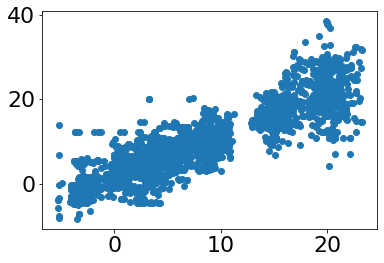

In [25]:
plt.scatter(games_data.bot_rank,games_data.user_rank)

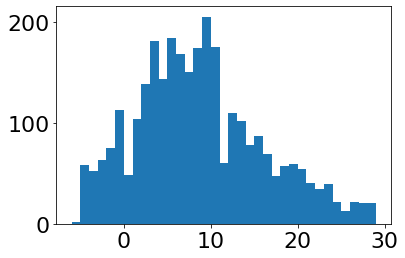

In [26]:
plt.hist(games_data.user_rank,bins=range(-6,30));

In [27]:
moves_data = moves_data.loc[moves_data.game_id.map(lambda x: x in games_data.index)] # race cond?

In [28]:
user_moves = moves_data[moves_data.move_color==moves_data.user_color]
user_moves['rank'] = games_data.loc[user_moves.game_id].user_rank.values

bot_moves = moves_data[moves_data.move_color!=moves_data.user_color]
bot_moves['rank'] = games_data.loc[bot_moves.game_id].bot_rank.values
labels = ['users','bots']

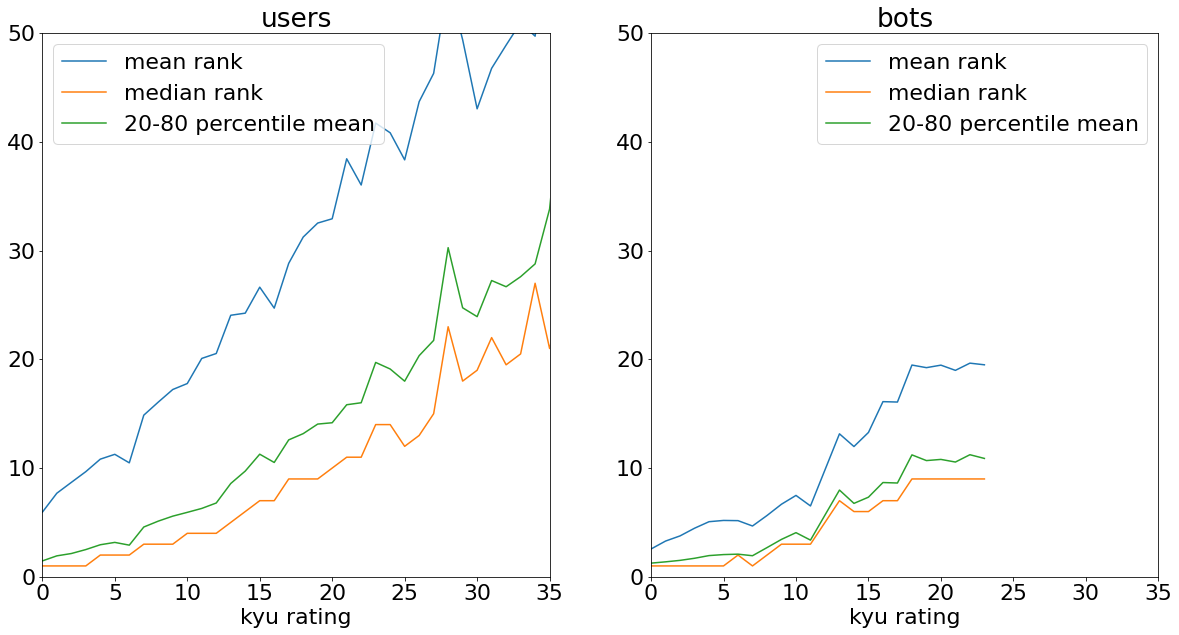

In [29]:
plt.figure(figsize=(20,10))
for i,moves in enumerate([user_moves,bot_moves]):
    stats = [(r,df.policy_rank.mean(),df.policy_rank.median(),outlier_free_stats(df.policy_rank.values),df.shape[0]) 
              for r,df in moves.groupby(moves['rank'].round())]    
    rank, mean, median, outlier_free_mean, sample_size = zip(*stats)
    plt.subplot(1,2,i+1)
    plt.plot(rank,mean,rank,median,rank,outlier_free_mean)
    plt.xlabel('kyu rating')
    plt.legend(['mean rank','median rank','20-80 percentile mean'])
    plt.title(labels[i])
    plt.ylim([0,50])
    plt.xlim([0,35])

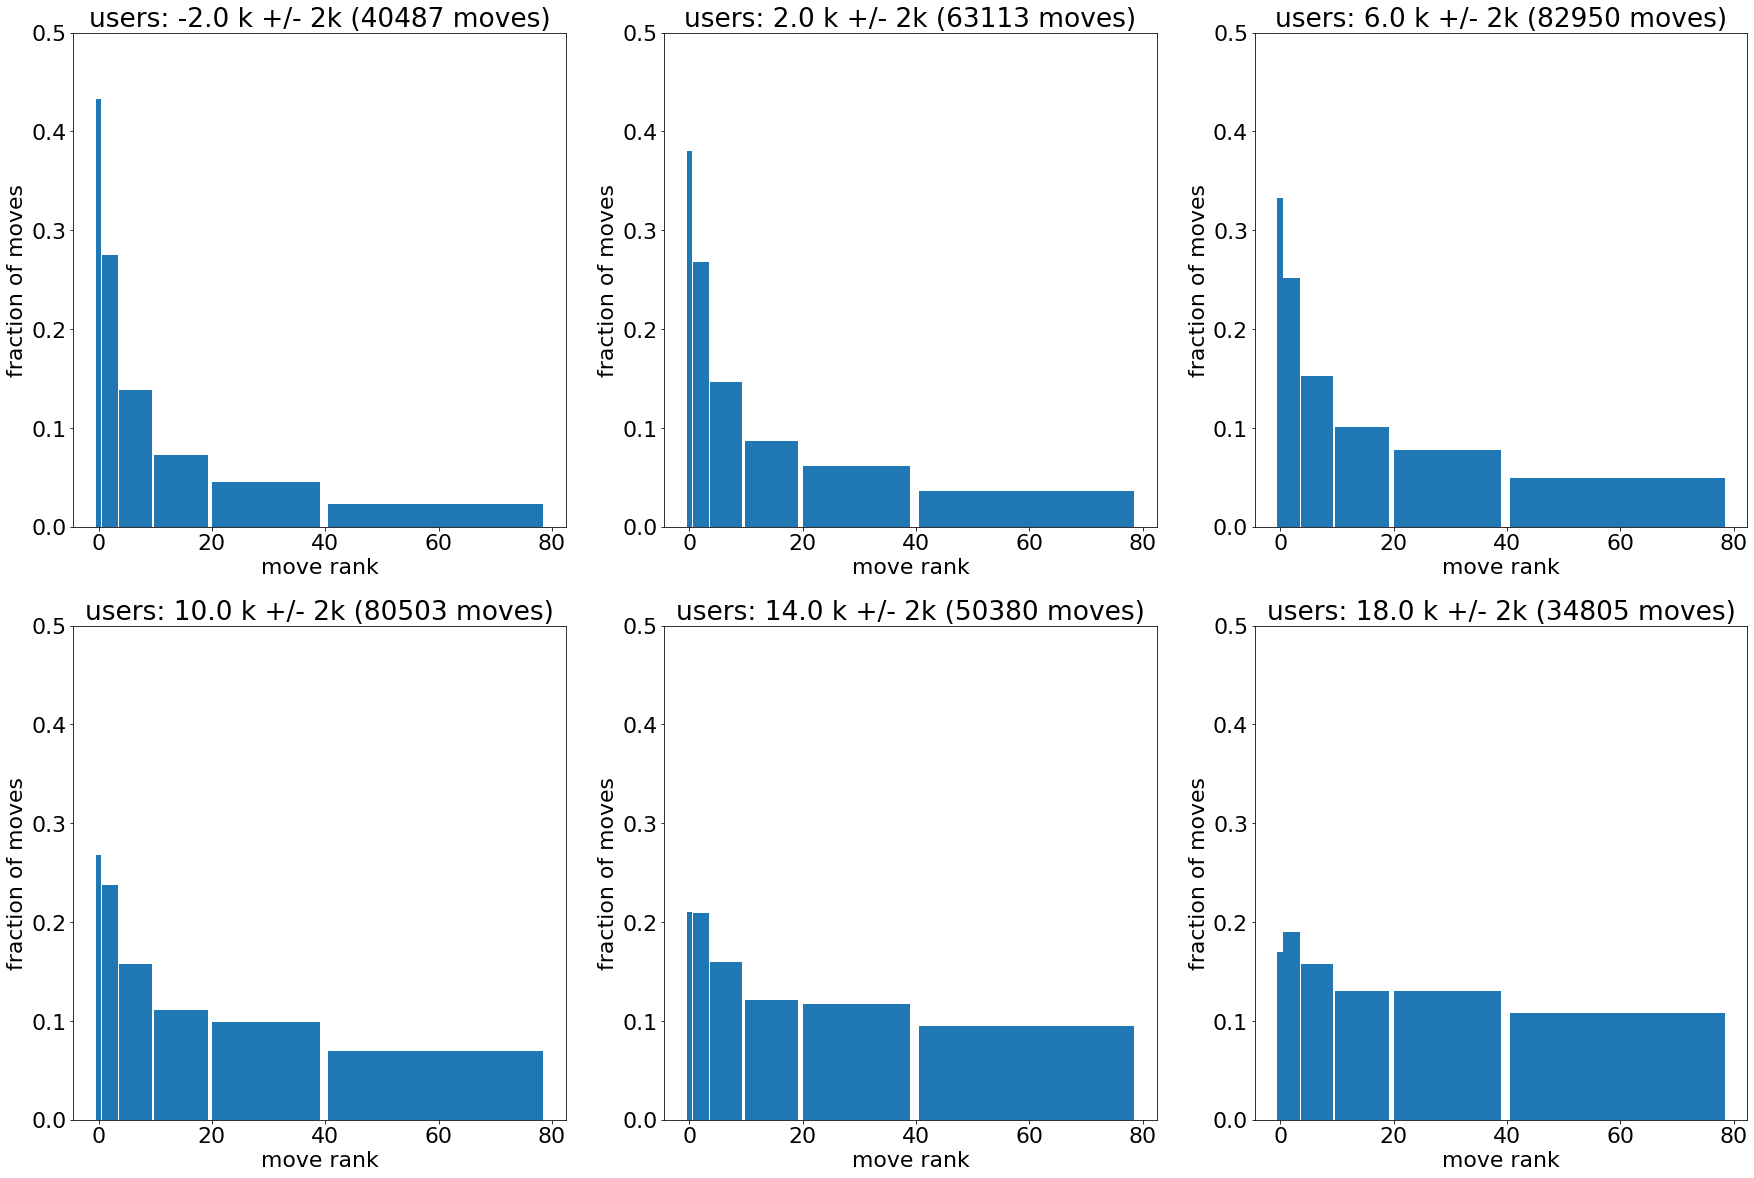

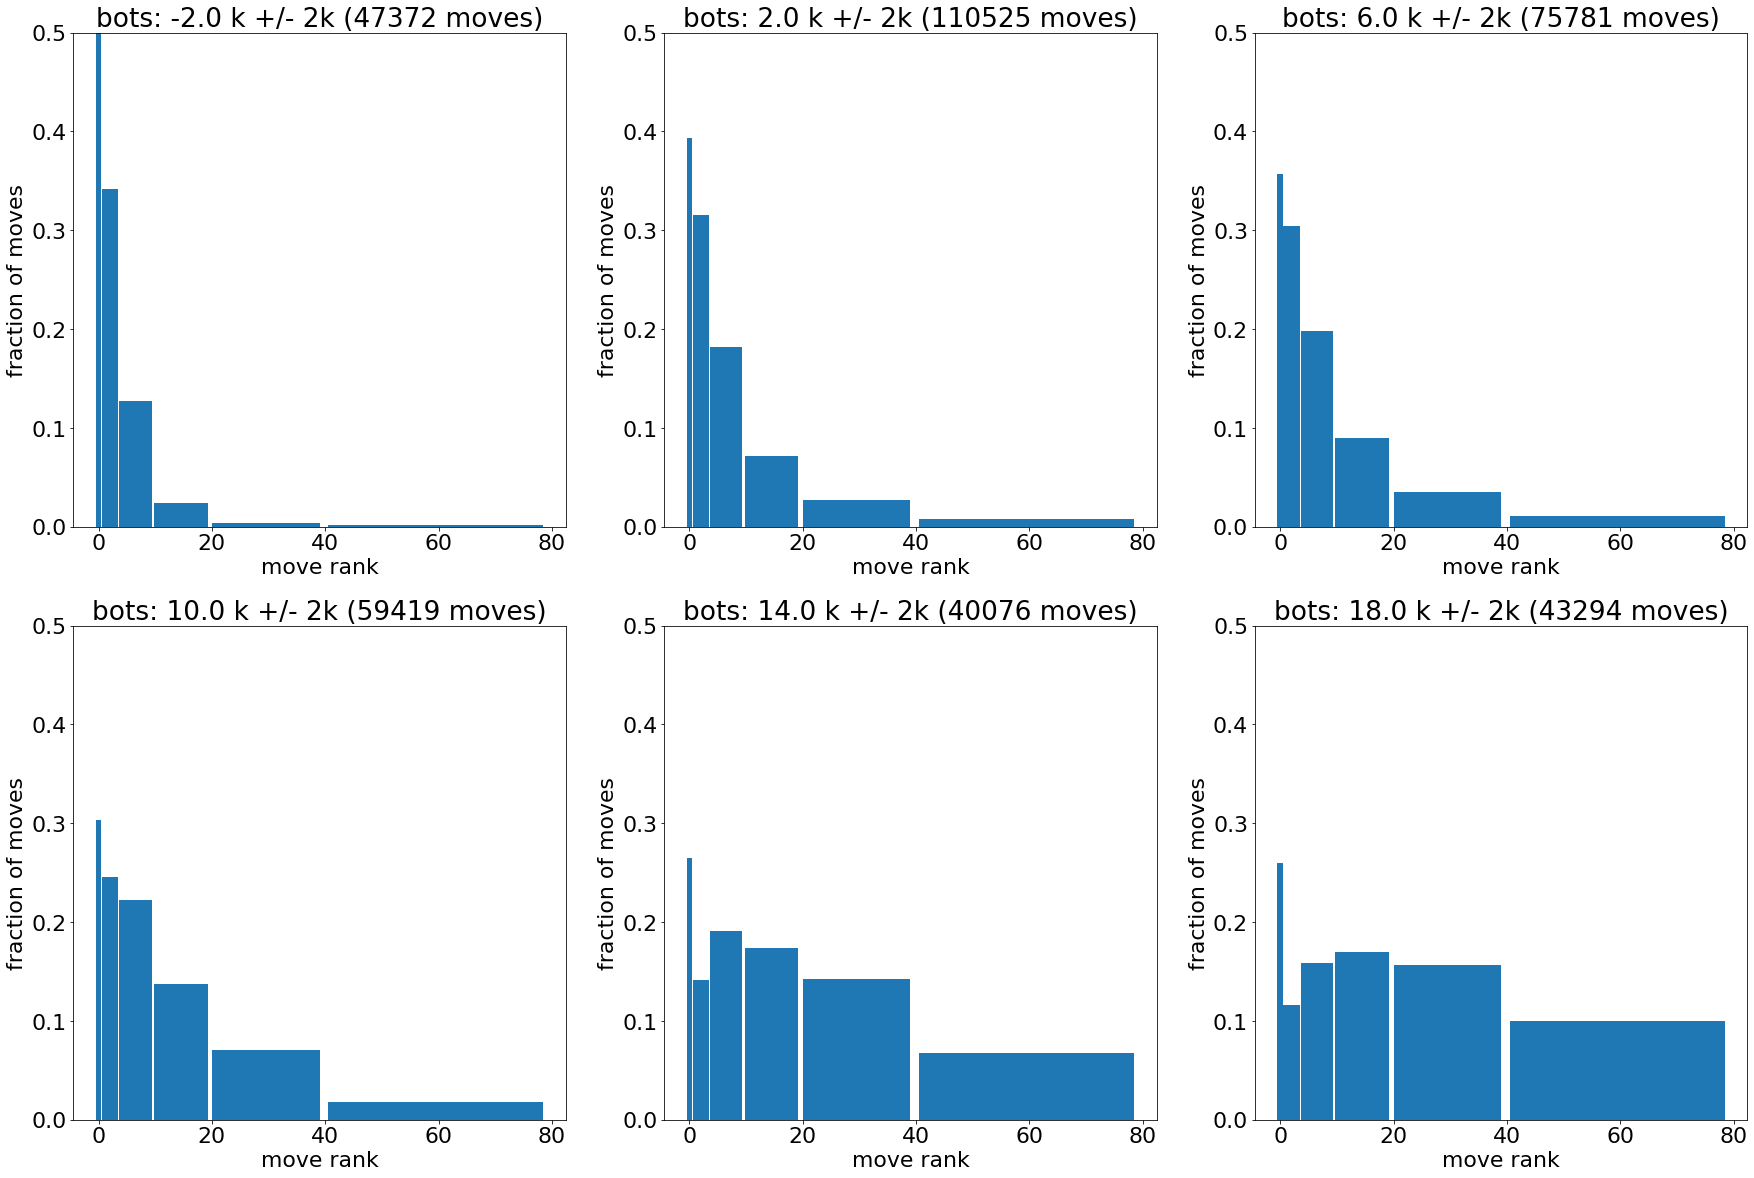

In [30]:
for i,moves in enumerate([user_moves,bot_moves]):
    s = 1
    plt.figure(figsize=(30,20))
    binned_rank = ((moves['rank']-2)/4).round()*4+2
    for r,df in moves[(binned_rank >= -2) & (binned_rank <= 18)].groupby(binned_rank):
        plt.subplot(2, 3, s); s=s+1
        normalized_histogram(df.policy_rank.values,bins=[-0.5,0.5,3.5,9.5,19.5,39.5,79.5],rwidth=0.95)
        plt.title(f"{labels[i]}: {r} k +/- 2k ({df.shape[0]} moves)")
        plt.xlabel('move rank')
        plt.ylabel('fraction of moves')
        plt.ylim([0,0.5])

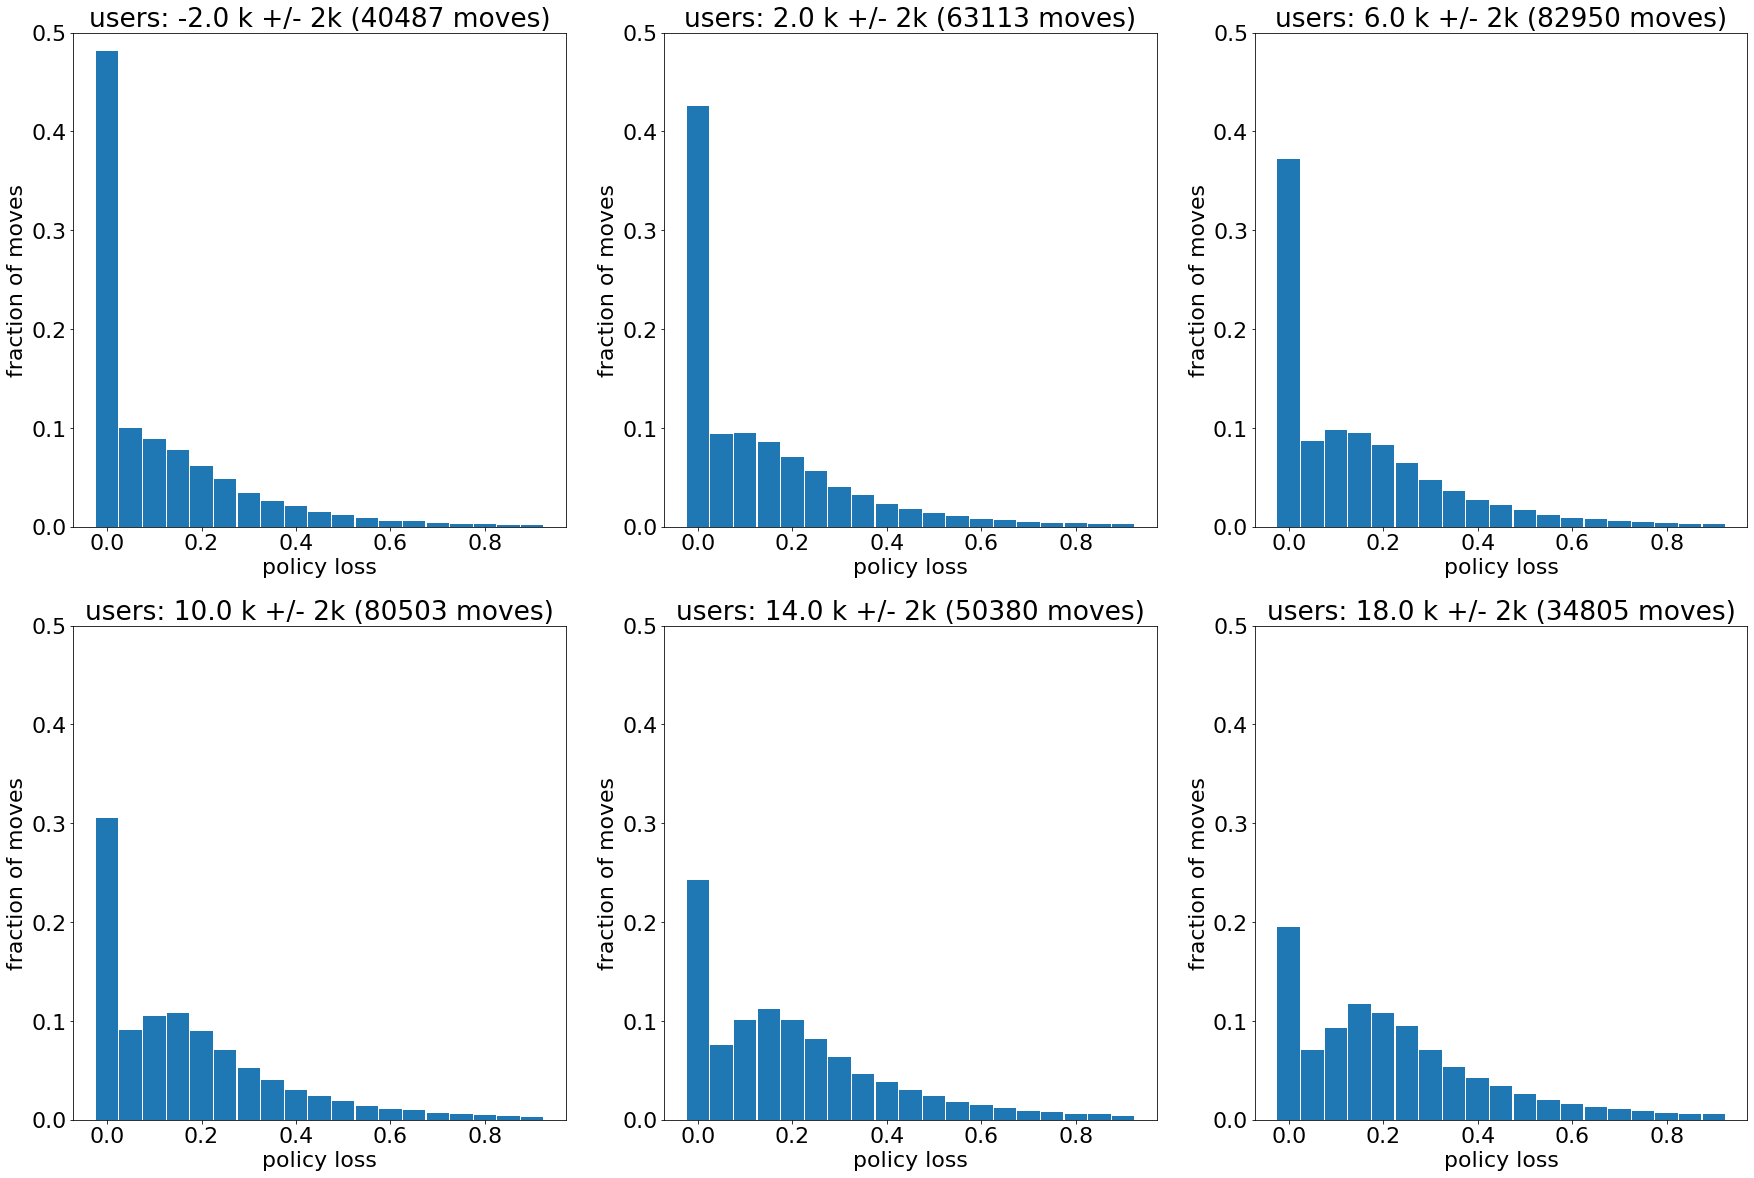

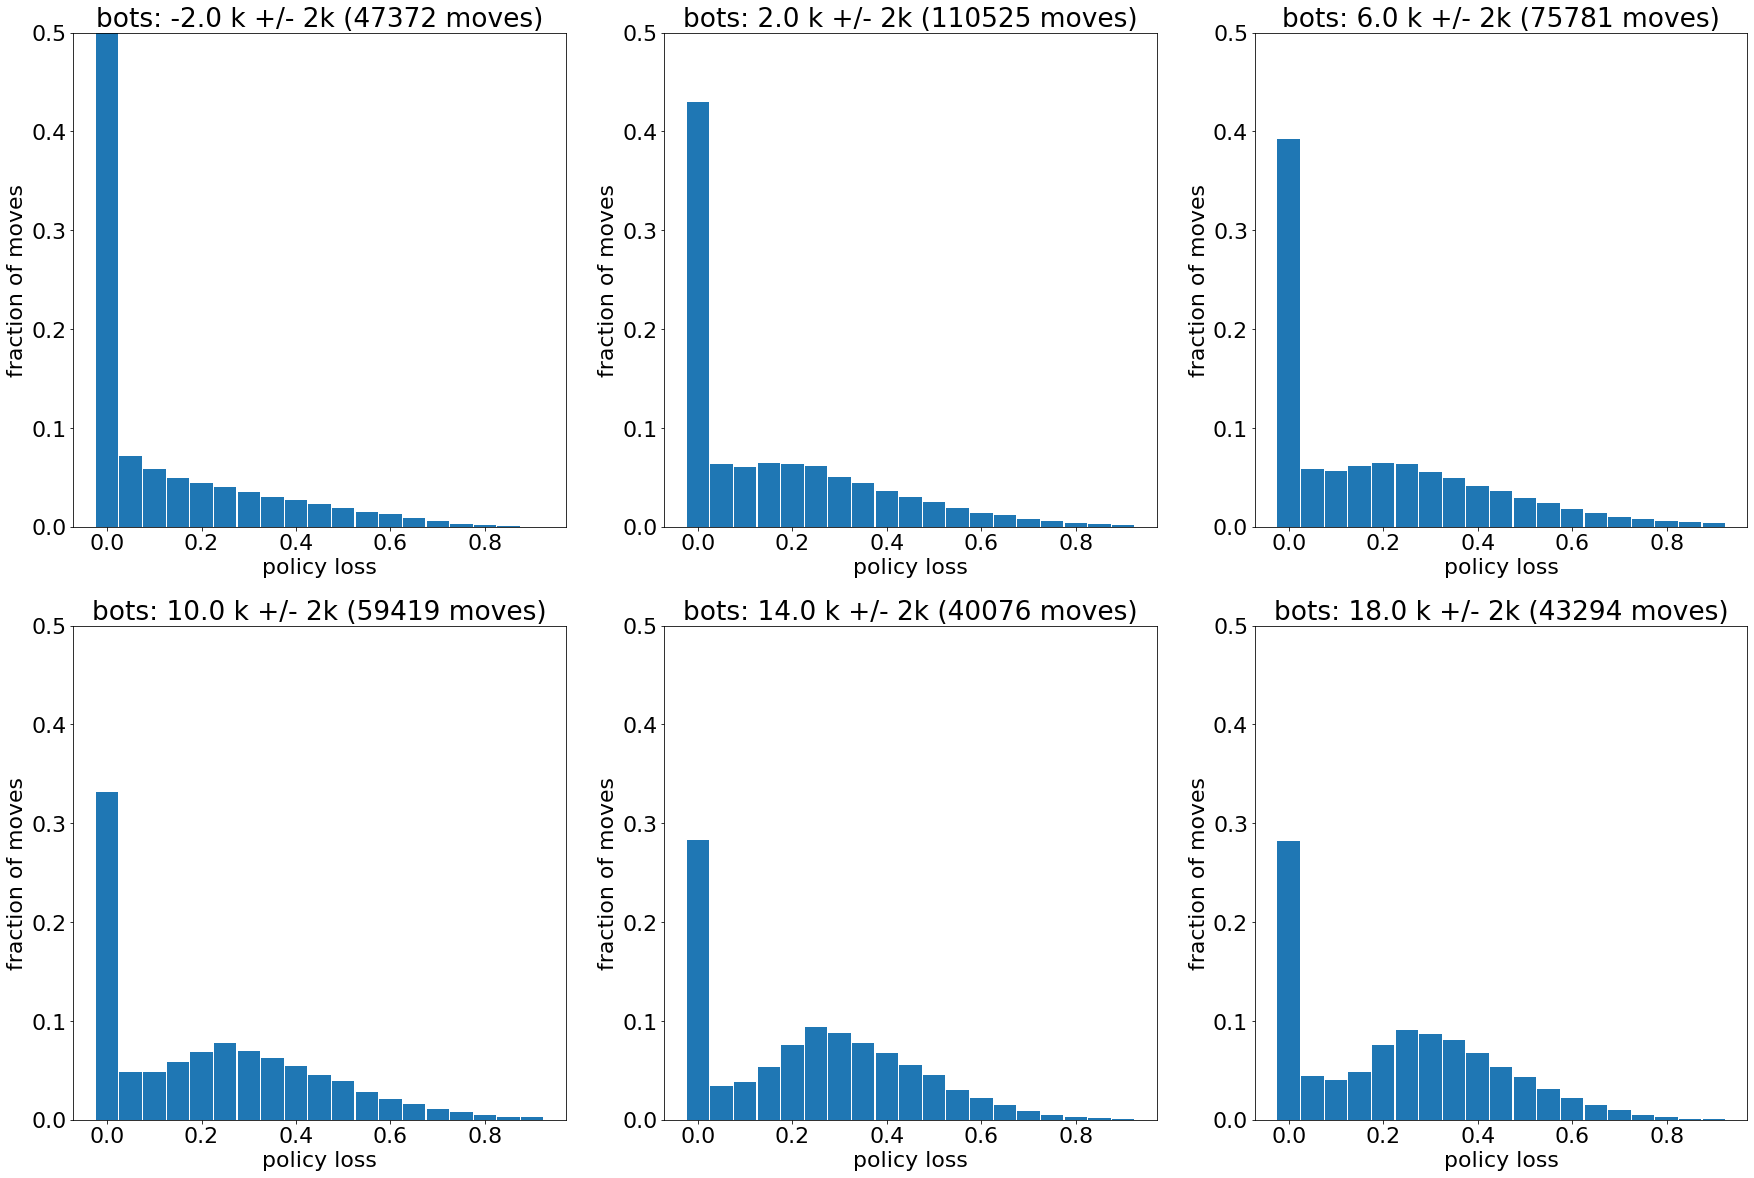

In [31]:
for i,moves in enumerate([user_moves,bot_moves]):
    s = 1
    plt.figure(figsize=(30,20))
    binned_rank = ((moves['rank']-2)/4).round()*4+2
    for r,df in moves[(binned_rank >= -2) & (binned_rank <= 18)].groupby(binned_rank):
        plt.subplot(2, 3, s); s=s+1
        normalized_histogram(df.top_value - df.policy_value,bins=np.arange(-0.025,0.975,0.05),rwidth=0.95)
        plt.title(f"{labels[i]}: {r} k +/- 2k ({df.shape[0]} moves)")
        plt.xlabel('policy loss')
        plt.ylabel('fraction of moves')
        plt.ylim([0,0.5])

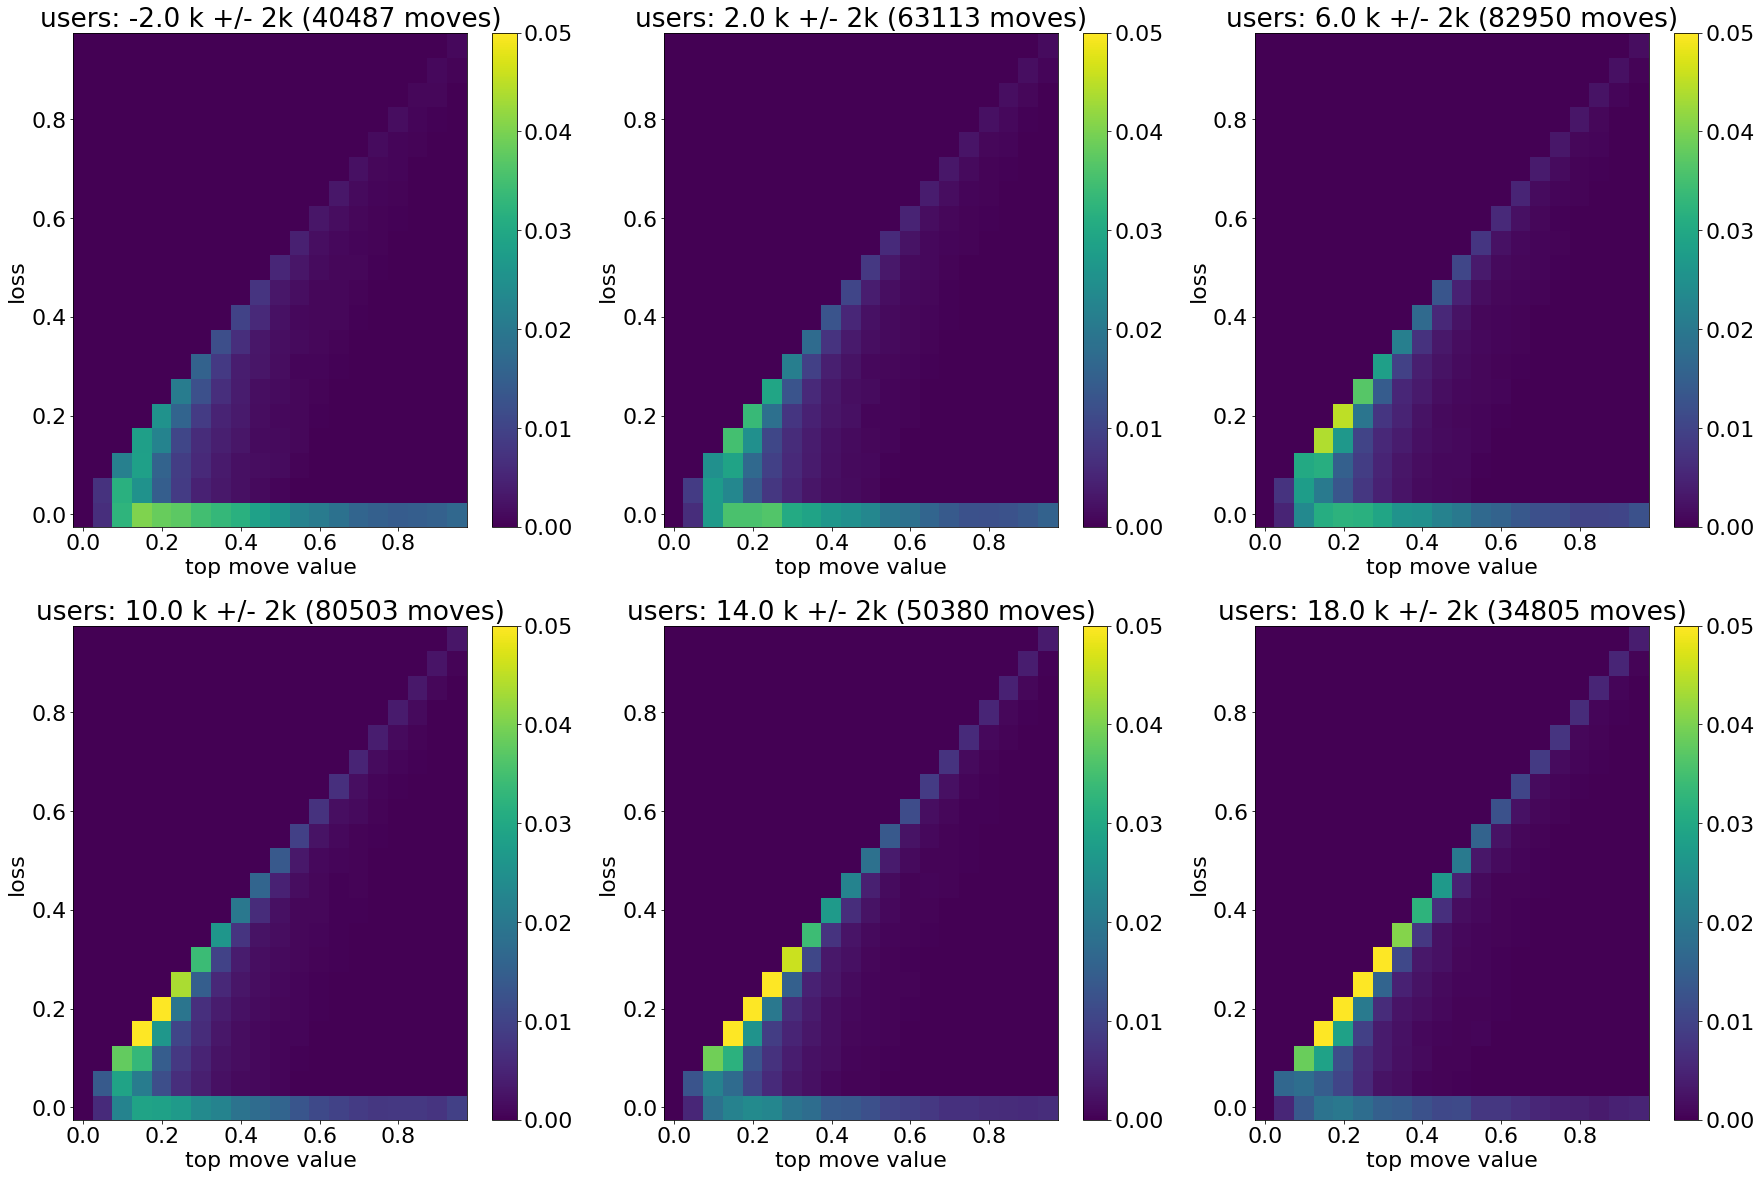

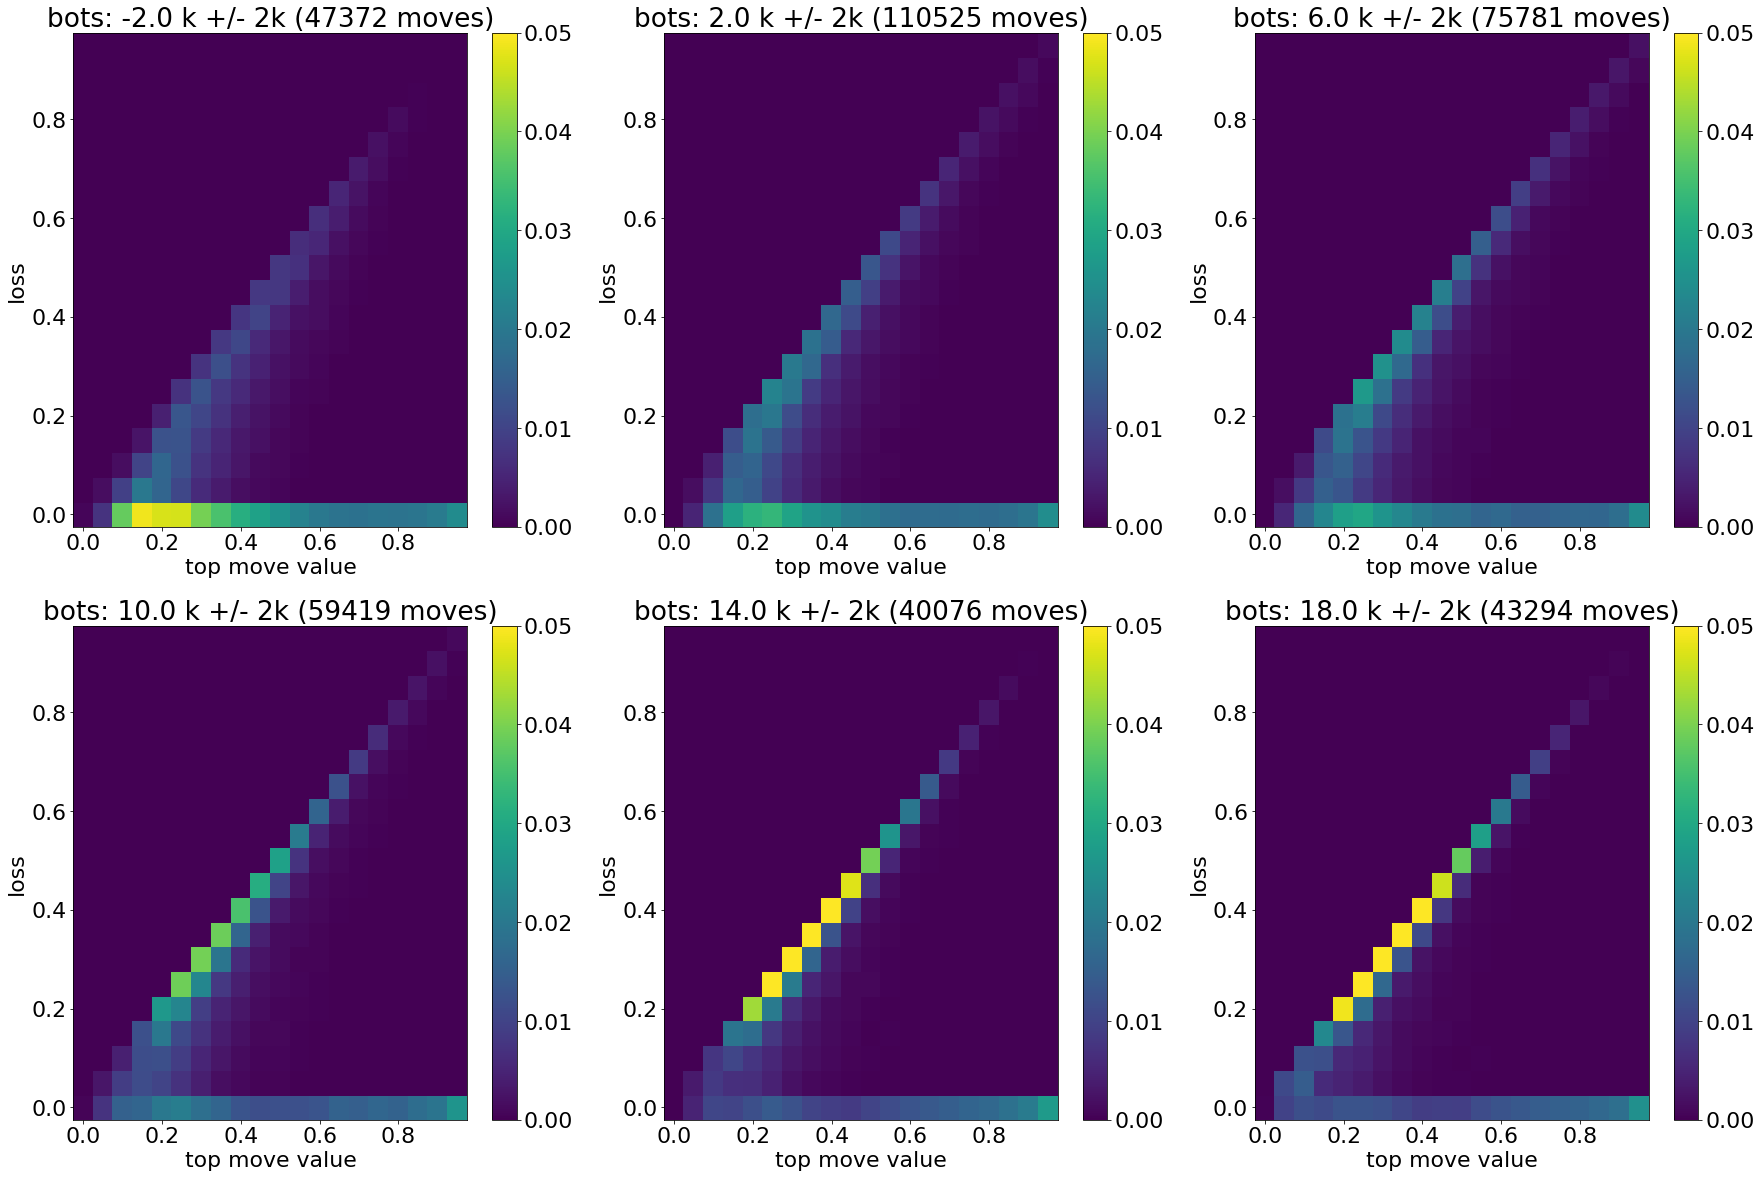

In [32]:
bins = np.arange(-0.025,1.025,0.05)
for i,moves in enumerate([user_moves,bot_moves]):
    s = 1
    plt.figure(figsize=(30,20))
    binned_rank = ((moves['rank']-2)/4).round()*4+2
    
    for r,df in moves[(binned_rank >= -2) & (binned_rank <= 18)].groupby(binned_rank):
        plt.subplot(2, 3, s); s=s+1
        weights = np.ones_like(df.top_value) / len(df.top_value)
        plt.hist2d(df.top_value, df.top_value - df.policy_value,
                            bins=[bins,bins],weights=weights,vmin=0, vmax=0.05)
        plt.title(f"{labels[i]}: {r} k +/- 2k ({df.shape[0]} moves)")
        plt.xlabel('top move value')
        plt.ylabel('loss')
        plt.colorbar()

Text(0.5, 1.0, 'bot moves top policy value')

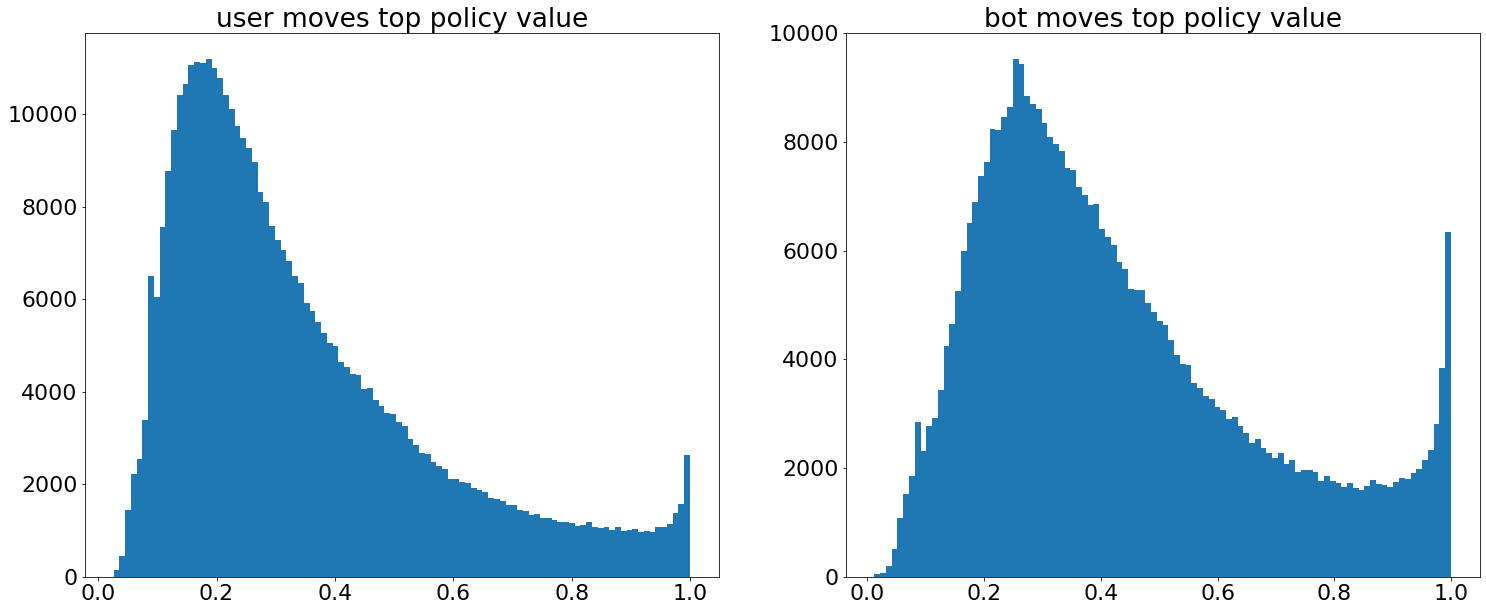

In [33]:
plt.figure(figsize=(25,10))
plt.subplot(1,2,1); plt.hist(user_moves.top_value,bins=100); plt.title('user moves top policy value')
plt.subplot(1,2,2); plt.hist(bot_moves.top_value,bins=100); plt.title('bot moves top policy value')

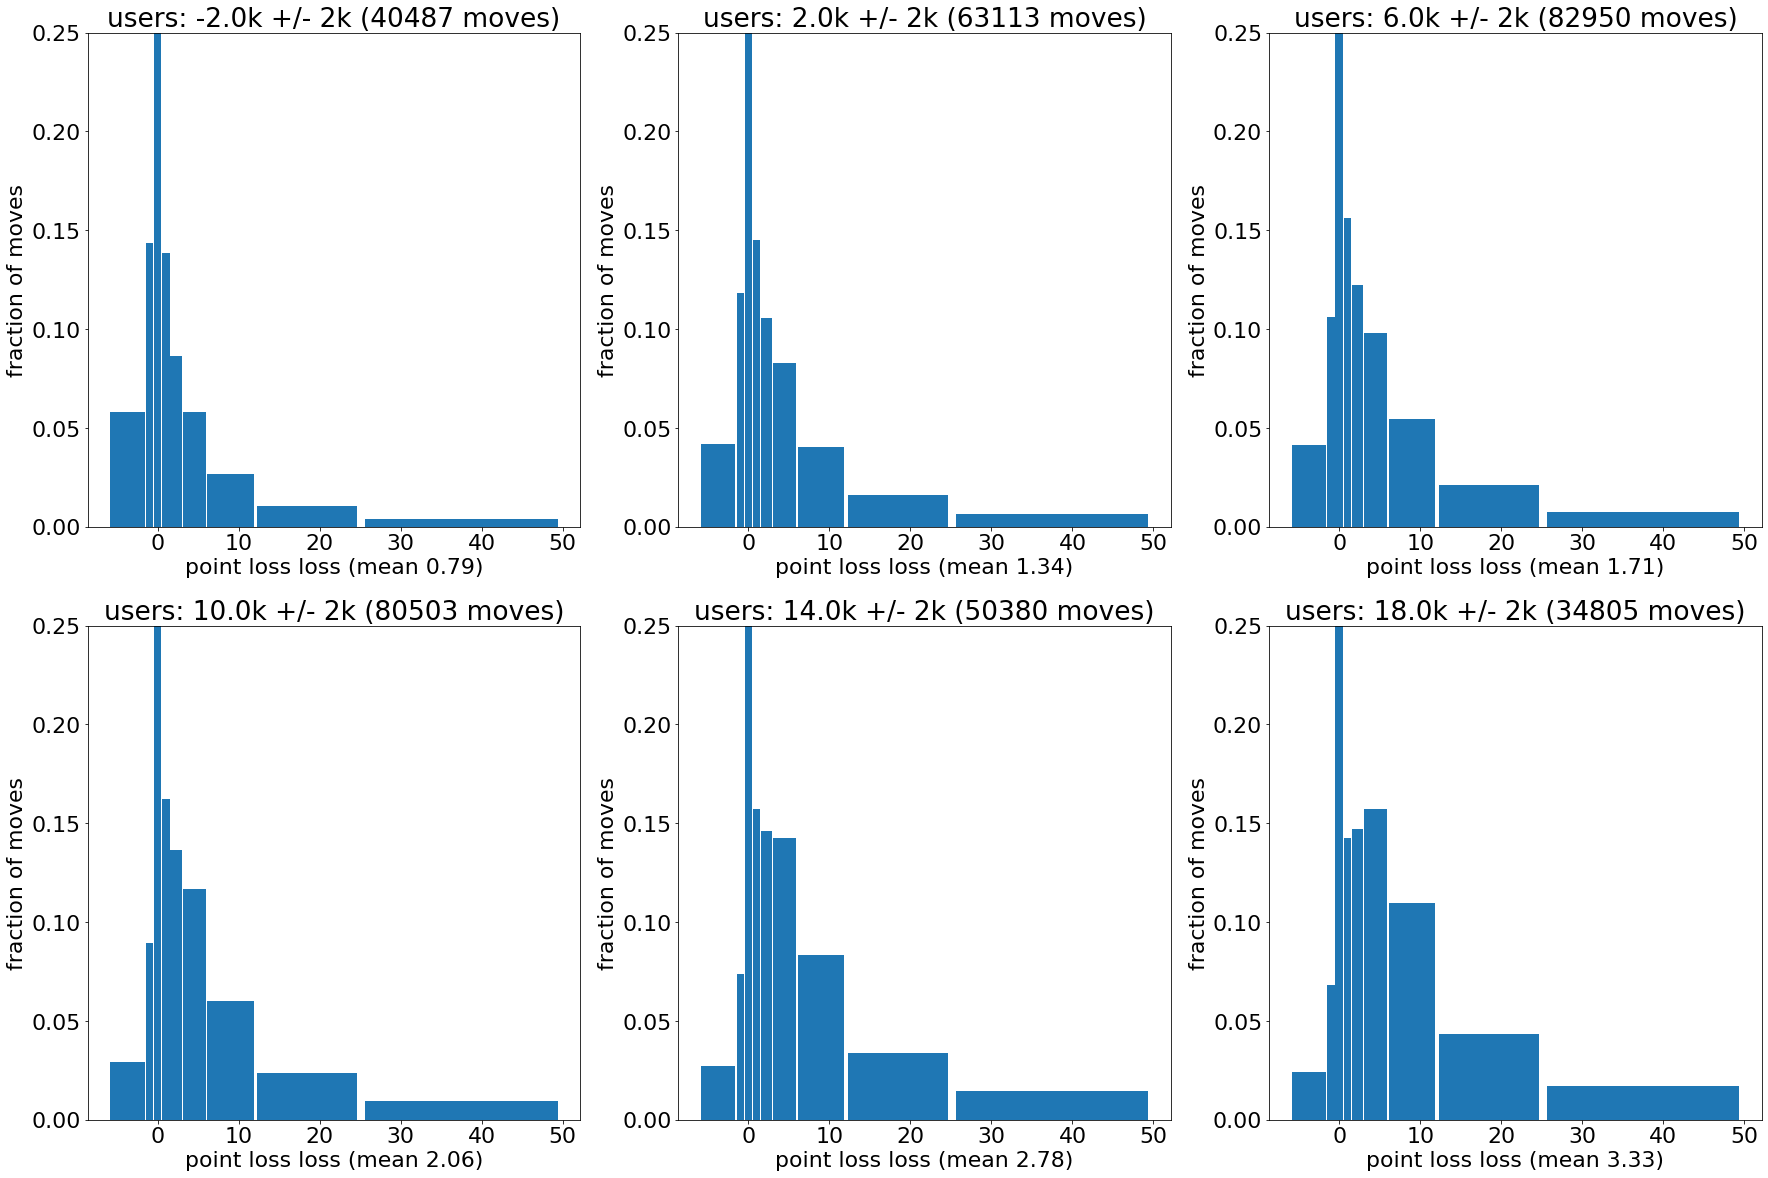

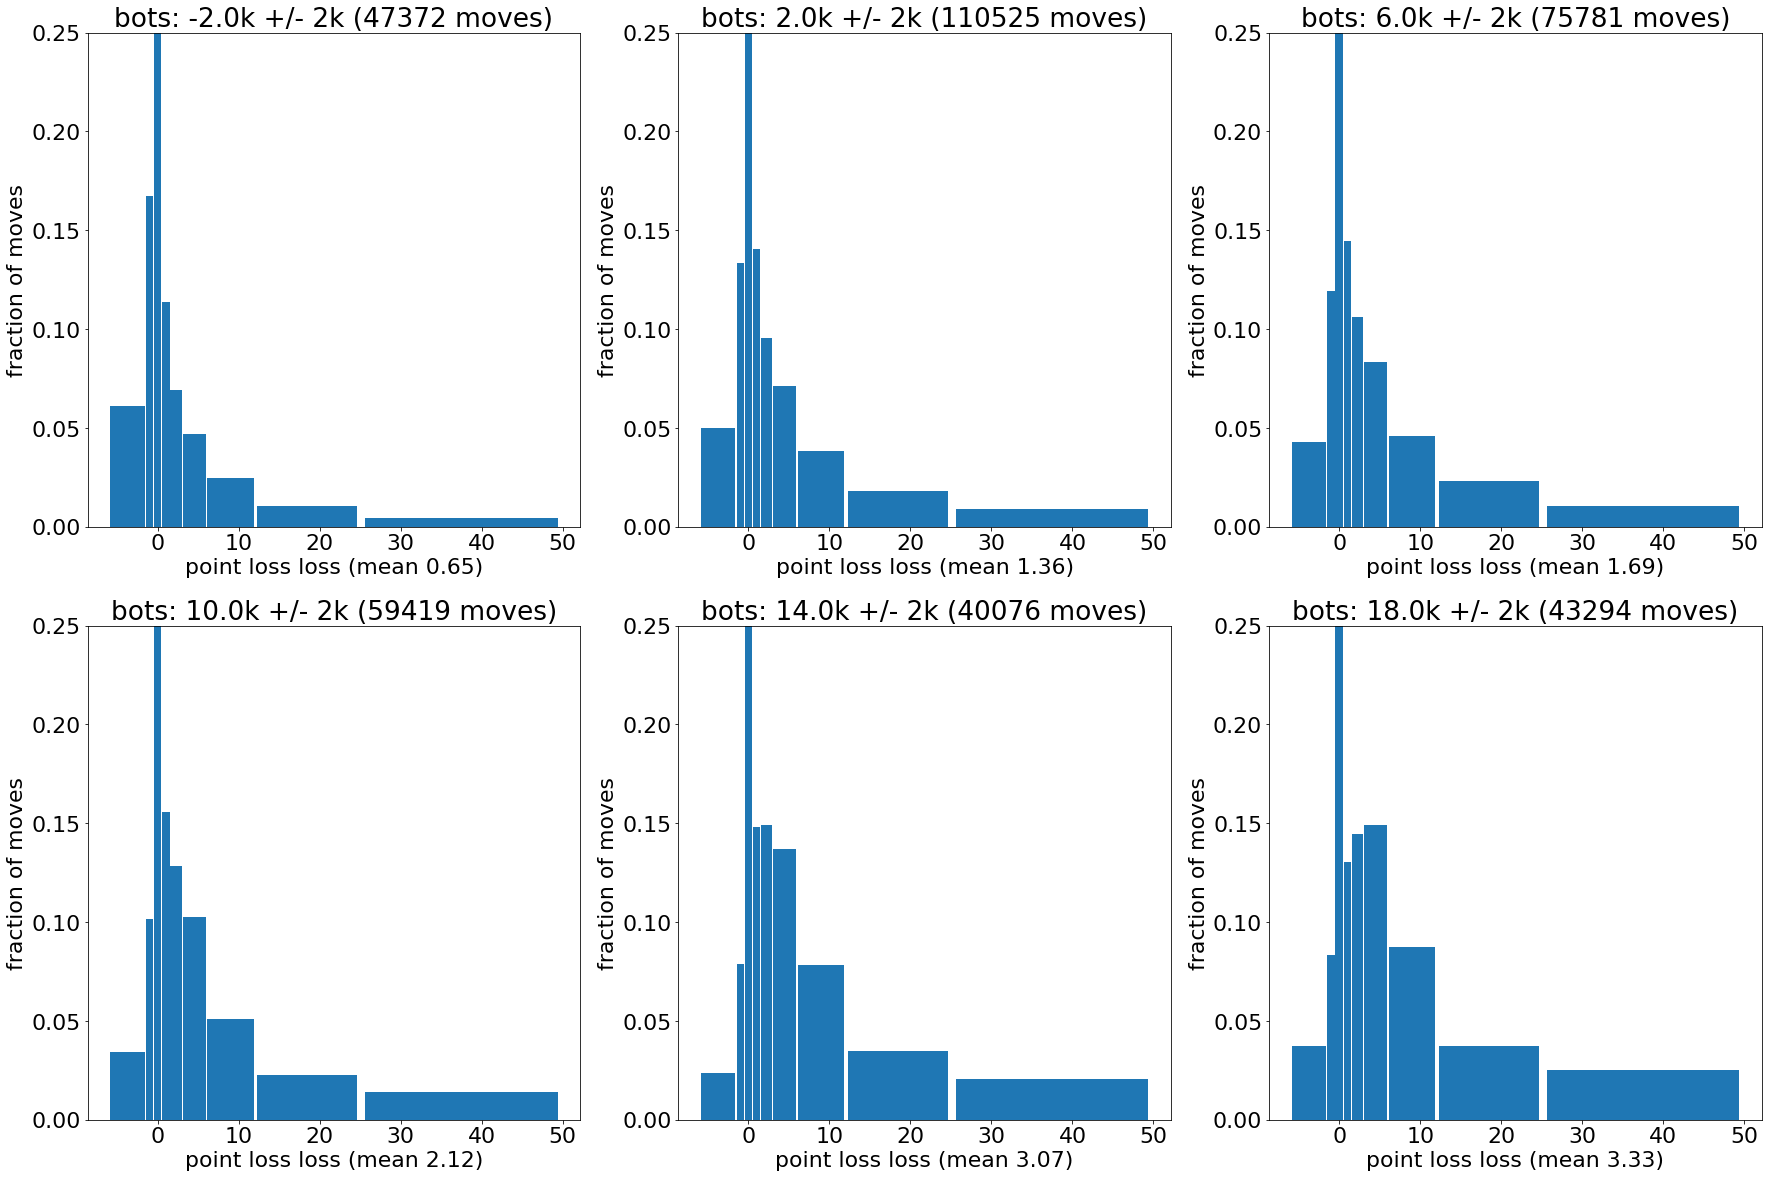

In [34]:
for i,moves in enumerate([user_moves,bot_moves]):
    s = 1
    plt.figure(figsize=(30,20))
    binned_rank = ((moves['rank']-2)/4).round()*4+2
    for r,df in moves[(binned_rank >= -2) & (binned_rank <= 18)].groupby(binned_rank):
        plt.subplot(2, 3, s); s=s+1
        normalized_histogram(df.points_lost.clip(-6,50),bins=[-6,-1.5,-0.5,0.5,1.5,3,6,12,25,50],rwidth=0.95)
        plt.title(f"{labels[i]}: {r}k +/- 2k ({df.shape[0]} moves)")
        plt.xlabel(f"point loss loss (mean {df.points_lost.mean():.2f})")
        plt.ylabel('fraction of moves')
        plt.ylim([0,0.25])

In [35]:
user_moves

,game_id,move,num_legal,policy_rank,policy_value,top_value,black_score,points_lost,move_color,user_color,rank
0,24718987,1,362,10,0.060001,0.086744,-0.678058,0.168583,black,black,13.950132
2,24718987,3,360,1,0.114710,0.567736,0.042733,-0.069419,black,black,13.950132
4,24718987,5,358,4,0.014992,0.456075,0.061339,0.291410,black,black,13.950132
6,24718987,7,356,72,0.000150,0.531250,-0.289156,1.693595,black,black,13.950132
8,24718987,9,354,6,0.002187,0.510714,0.313596,0.925460,black,black,13.950132
...,...,...,...,...,...,...,...,...,...,...,...
818383,24679322,259,115,4,0.029664,0.267764,-50.221146,0.821797,black,black,5.319702
818385,24679322,261,116,0,0.770453,0.770453,-50.085487,-0.463856,black,black,5.319702
818387,24679322,263,115,0,0.083254,0.083254,-50.827377,0.144365,black,black,5.319702
818389,24679322,265,114,0,0.089798,0.089798,-50.602839,-0.043565,black,black,5.319702


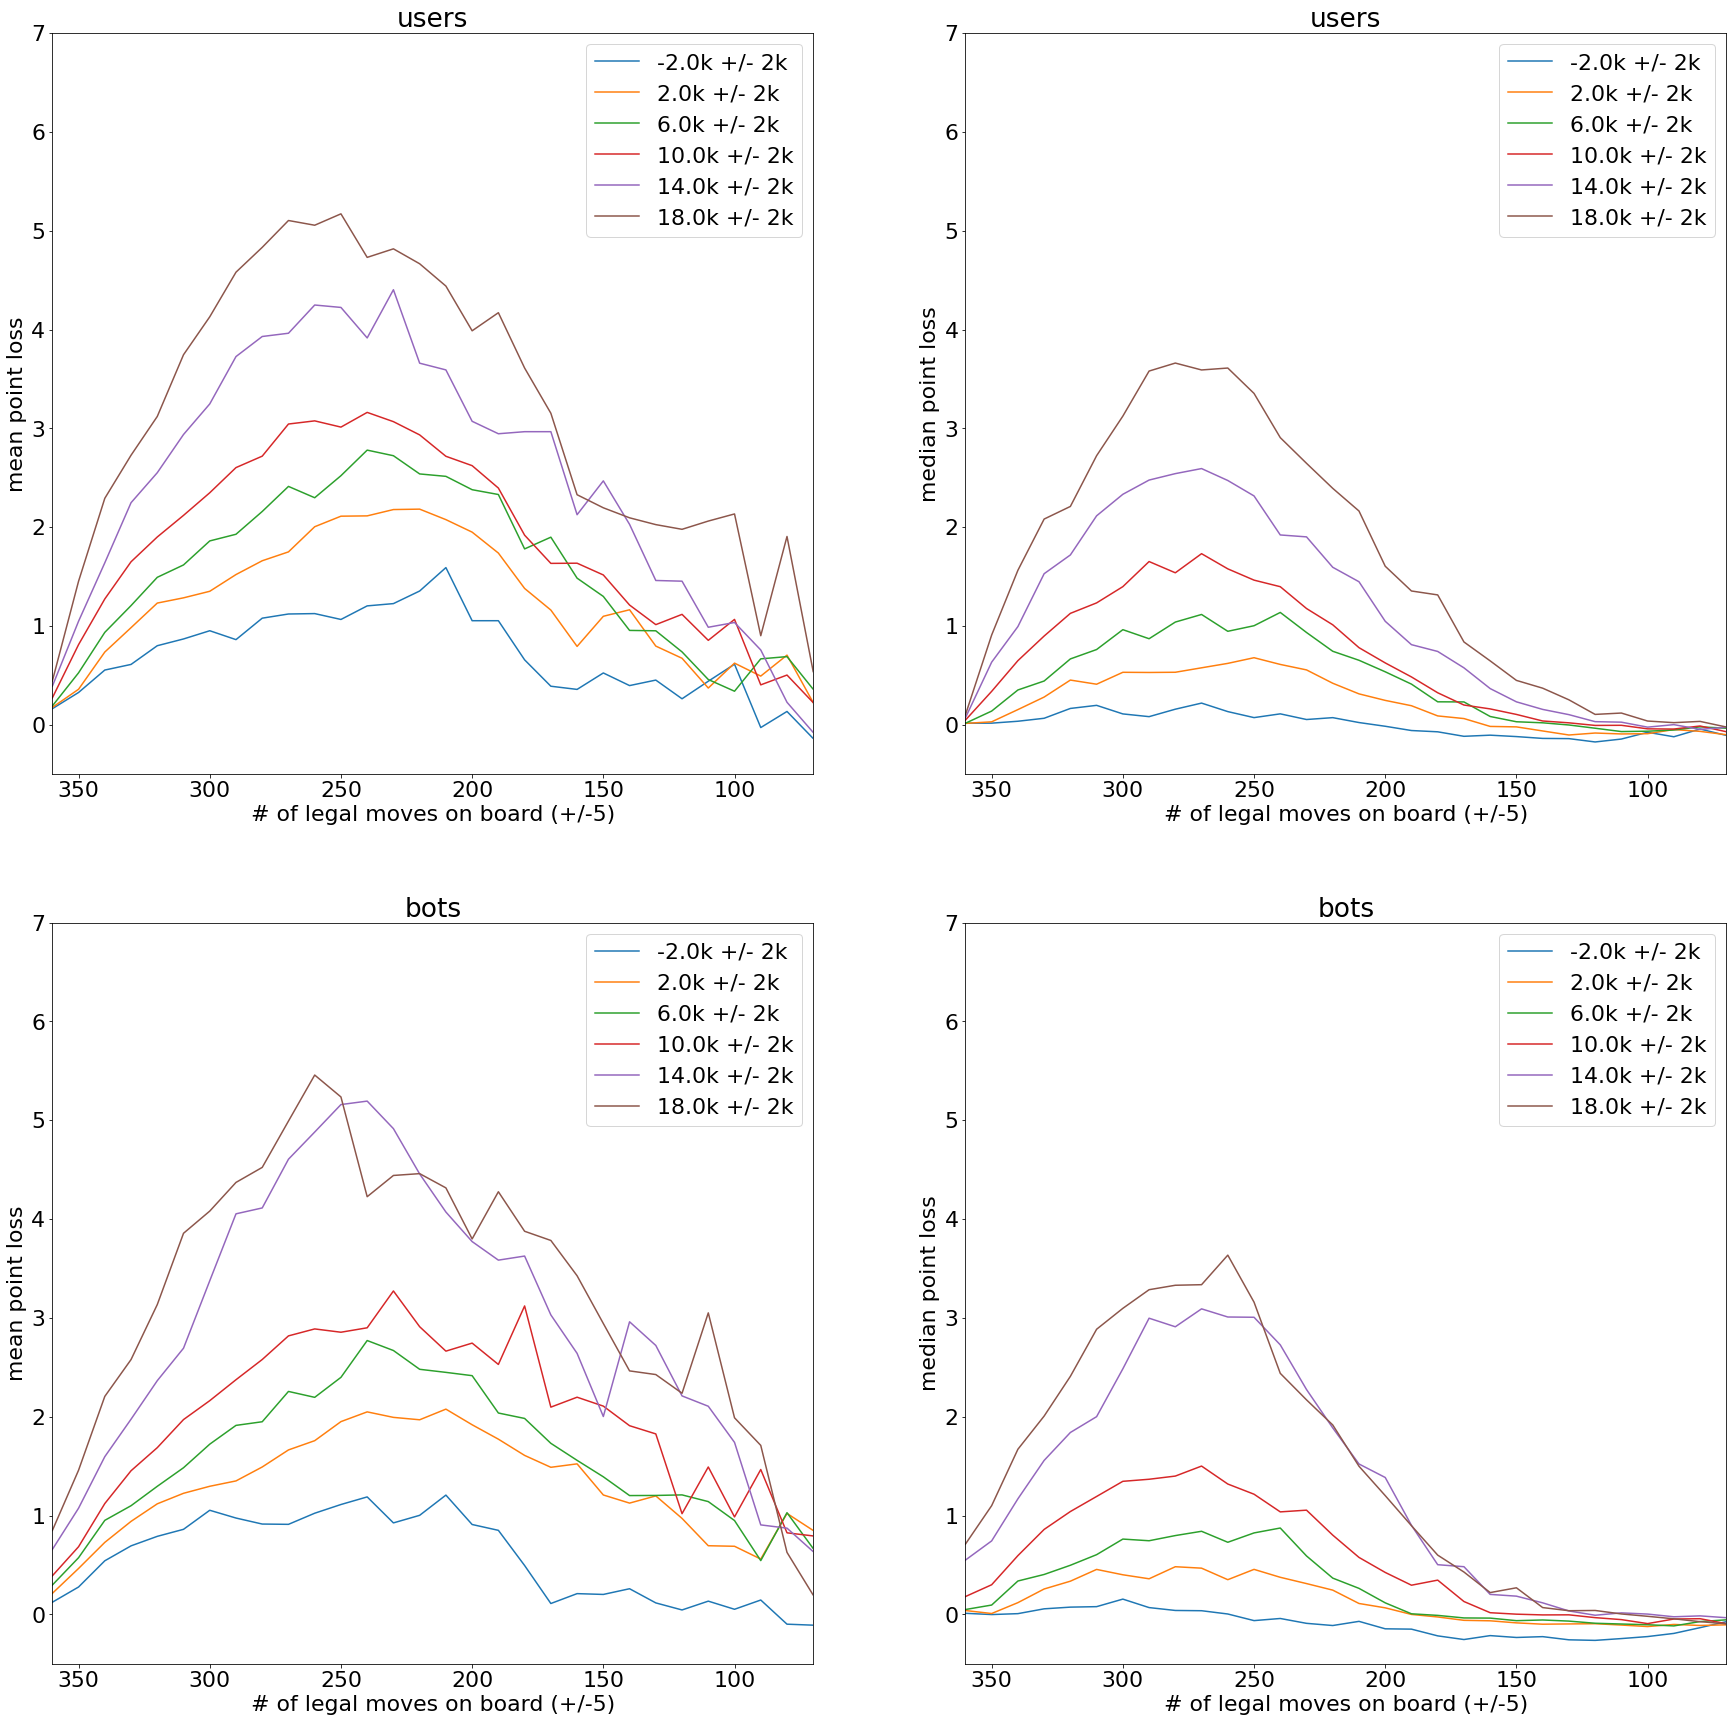

In [36]:
_, axs = plt.subplots(2,2,figsize=(30,30))
for i,moves in enumerate([user_moves,bot_moves]):
    binned_rank = ((moves['rank']-2)/4).round()*4+2
    legends = []
    for r,rdf in moves[(binned_rank >= -2) & (binned_rank <= 18)].groupby(binned_rank):
        binned_num_legal = (rdf.num_legal + 5) // 10
        m = rdf.groupby(binned_num_legal).points_lost.mean()
        axs[i][0].plot(m.index*10,m.values)
        m = rdf.groupby(binned_num_legal).points_lost.median()
        axs[i][1].plot(m.index*10,m.values)
        legends.append(f"{r}k +/- 2k")
    for s in range(2):
        axs[i][s].legend(legends)
        axs[i][s].set_title(labels[i])
        axs[i][s].set_xlabel(f"# of legal moves on board (+/-5)")
        axs[i][s].set_xlim(360,70) # sample size too small after
        axs[i][s].set_ylim(-0.5,7)
    axs[i][0].set_ylabel("mean point loss")
    axs[i][1].set_ylabel("median point loss")